In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
def image_loader(image_name, imsize=512):
    loader = transforms.Compose([
        transforms.Resize(imsize),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# example images
content_img = image_loader("./demo_imgs/chicago.jpg")
# resize the style image with respect to content image
style_img = image_loader("./demo_imgs/wave.jpg", content_img.size()[2:])

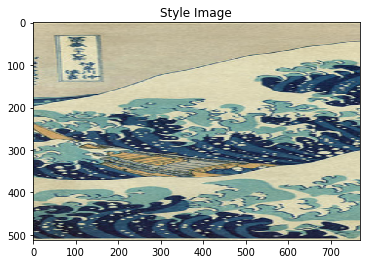

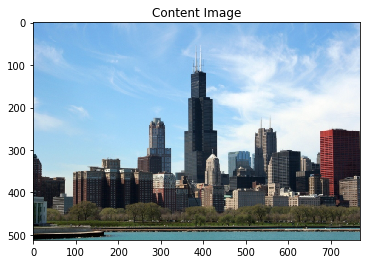

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
    def gram_matrix(input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [14]:
cnn_vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\shg03/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [02:07<00:00, 4.51MB/s]


In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [16]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, net_type=("vgg", 19),
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, init_norm=True):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []

    # normalization module
    if init_norm:
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)
    else:
        model = nn.Sequential()

    if net_type[0] == "vgg":
        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
    
    # botnet{l}_{b}
    elif net_type[0] == "res":
        l = 0
        temp = True
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                name = 'conv_start'
            elif isinstance(layer, nn.ReLU):
                name = 'relu_start'
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_start'
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_start'
            elif isinstance(layer, nn.Sequential):
                temp = False
                l += 1
                b = 0
                for sublayer in layer.children():
                    if net_type[1] in [18, 34]:
                        if isinstance(sublayer, models.resnet.BasicBlock):
                            b += 1
                            name = 'botnet{}_{}'.format(l, b)             
                        else:
                            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                    elif net_type[1] in [50, 101, 152]:
                        if isinstance(sublayer, models.resnet.Bottleneck):
                            b += 1
                            name = 'botnet{}_{}'.format(l, b)             
                        else:
                            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
                    else:
                        raise RuntimeError('Unexpected model layer input')
                        
                    model.add_module(name, sublayer)
                    
                    #i = 0
                    #for subsublayer in sublayer.children():
                    #    if isinstance(subsublayer, nn.Conv2d):
                    #        i += 1
                    #        name = name + '_conv{}'.format(i)
                    #    elif isinstance(subsublayer, nn.ReLU):
                    #        name = name + '_relu{}'.format(i)
                    #        subsublayer = nn.ReLU(inplace=False)
                    #    elif isinstance(subsublayer, nn.BatchNorm2d):
                    #        name = name + '_bn{}'.format(i)
                    
                    if name in content_layers:
                        # add content loss:
                        target = model(content_img).detach()
                        content_loss = ContentLoss(target)
                        model.add_module("content_loss_{}".format(l), content_loss)
                        content_losses.append(content_loss)

                    if name in style_layers:
                        # add style loss:
                        target_feature = model(style_img).detach()
                        style_loss = StyleLoss(target_feature)
                        model.add_module("style_loss_{}".format(l), style_loss)
                        style_losses.append(style_loss)

            else:
                continue
            
            if temp:
                model.add_module(name, layer)

                if name in content_layers:
                    # add content loss:
                    target = model(content_img).detach()
                    content_loss = ContentLoss(target)
                    model.add_module("content_loss_{}".format(i), content_loss)
                    content_losses.append(content_loss)

                if name in style_layers:
                    # add style loss:
                    target_feature = model(style_img).detach()
                    style_loss = StyleLoss(target_feature)
                    model.add_module("style_loss_{}".format(i), style_loss)
                    style_losses.append(style_loss)
        
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    
    print(model)

    return model, style_losses, content_losses

In [17]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, net_type=("vgg", 19), num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers=content_layers_default,
                       style_layers=style_layers_default, init_norm=True):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, net_type=net_type, content_layers=content_layers,
                               style_layers=style_layers, init_norm=init_norm)
    optimizer = get_input_optimizer(input_img)

    result_img_list = []
    loss_style = []
    loss_cont = []
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            loss_style.append(style_score)
            loss_cont.append(content_score)

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                temp = copy.deepcopy(input_img)
                result_img_list.append(temp)

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    #return input_img
    return result_img_list, loss_style, loss_cont

# Experiment

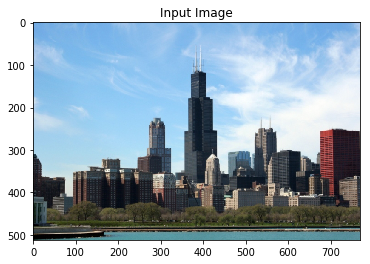

In [18]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [19]:
CONTENT_LAYERS = ('relu_10', 'relu_14')
STYLE_LAYERS = ('relu_1', 'relu_2' 'relu_3', 'relu_5', 'relu_9', 'relu_13')
premodel = cnn_vgg19
steps = 300

In [22]:
outputs, style_loss, cont_loss = run_style_transfer(premodel, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=steps, content_layers=CONTENT_LAYERS, style_layers=STYLE_LAYERS)

for out in outputs:
    plt.figure()
    imshow(out, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

Building the style transfer model..


C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (style_loss_1): StyleLoss()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (style_loss_5): StyleLoss()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Conv2d(256, 256, kernel_size=(3,

KeyboardInterrupt: 